<a href="https://colab.research.google.com/github/federico-bassi/cats_dogs_image_classification/blob/main/bassi_federico_993443.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats or dogs?
This script contains the code used for the Machine Learning Project "Cats or Dogs?".

In [ ]:
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
from PIL import Image
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
from os.path import isfile,join, exists
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import statistics as st

In [ ]:
pip uninstall keras-preprocessing -y

Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [ ]:
pip install -q -U git+https://github.com/keras-team/keras-preprocessing.git

In [ ]:
pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

## Get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CatsDogs.zip', 'r') # Open the zip file containing all the images
zip_ref.extractall('/tmp') # Extract the file in /tmp folder
zip_ref.close()

In [ ]:
print("Cats photos :" +str(len(os.listdir('./../tmp/CatsDogs/Cats'))))
print("Dogs photos :" +str(len(os.listdir('./../tmp/CatsDogs/Dogs'))))


Cats photos :12500
Dogs photos :12500


## Remove deprecated images

In [ ]:
# Define the paths
cat_path = glob.glob("./../tmp/CatsDogs/Cats/*.jpg")
dog_path = glob.glob("./../tmp/CatsDogs/Dogs/*.jpg")
paths = list([cat_path, dog_path])

In [ ]:
# Remove the images w/ size = 0
for path in paths:
  for filename in path:  
    if os.stat(filename).st_size==0:
      os.remove(filename)

In [ ]:
num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        fobj = open(filename, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(filename)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
# Print the number of photos in each class after remotion
print("Cats photos after remotion: " +str(len(os.listdir('/tmp/CatsDogs/Cats'))))
print("Dogs photos after remotion: " +str(len(os.listdir('/tmp/CatsDogs/Dogs'))))

Cats photos after remotion: 11741
Dogs photos after remotion: 11669


## Dataframe for the flow_from_dataframe function

In [ ]:
df_cat = pd.DataFrame({"file_name": [f"/tmp/CatsDogs/Cats/{i}" for i in os.listdir('/tmp/CatsDogs/Cats')]})
df_cat["label"] = "cat"
df_dog = pd.DataFrame({"file_name": [f"/tmp/CatsDogs/Dogs/{i}" for i in os.listdir('/tmp/CatsDogs/Dogs')]})
df_dog["label"] = "dog"
ash_df = pd.concat([df_cat, df_dog], ignore_index=True)
ash_df = ash_df.sample(frac=1, random_state = 666).reset_index(drop=True)
ash_df

,file_name,label
0,/tmp/CatsDogs/Cats/11863.jpg,cat
1,/tmp/CatsDogs/Dogs/9265.jpg,dog
2,/tmp/CatsDogs/Dogs/8177.jpg,dog
3,/tmp/CatsDogs/Dogs/4371.jpg,dog
4,/tmp/CatsDogs/Cats/8795.jpg,cat
...,...,...
23405,/tmp/CatsDogs/Cats/93.jpg,cat
23406,/tmp/CatsDogs/Cats/12395.jpg,cat
23407,/tmp/CatsDogs/Cats/11496.jpg,cat
23408,/tmp/CatsDogs/Cats/6761.jpg,cat


In [ ]:
# Split in training+validation set and test set
train_val_df, test_df = train_test_split(ash_df, test_size=0.2, random_state = 666)

In [ ]:
# Split training+validation set in training and validation set
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state = 666)

## Generators

In [ ]:
# Image Data Generators
image_data_generator = ImageDataGenerator(rescale=1./255.)

In [ ]:
# Flow From DataFrame
train_valid_generator = image_data_generator.flow_from_dataframe(dataframe=train_val_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

test_generator=image_data_generator.flow_from_dataframe(dataframe = test_df, directory=None,
                                                          x_col="file_name", y_col="label",
                                                          batch_size=64, 
                                                          seed=123, shuffle=True, class_mode="binary",
                                                          target_size=(180,180))

train_generator = image_data_generator.flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

valid_generator = image_data_generator.flow_from_dataframe(dataframe= val_df, 
                                                            directory=None, x_col="file_name",
                                                            y_col="label",
                                                            batch_size=64, seed=666,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=(180,180))

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.


## Model 1: VGG-2

In [ ]:
# Model 1 Specification
def model_1_specification():
    inputs = keras.Input(shape = (180,180,3))
    
    # First block w/ 32 filters
    x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    
    # Fully Connected Layers
    x = layers.Dense(128, activation = "relu")(x)   
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# Compile
model = model_1_specification()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [ ]:
# Fit, plot and validate the model
step_size_train = train_valid_generator.n//train_valid_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator= train_valid_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=test_generator,
                    validation_steps=step_size_validation,
                    epochs=50,
                    callbacks=[tensorboard])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
292/292 [==============================] - 92s 269ms/step - loss: 0.7203 - accuracy: 0.6573 - val_loss: 0.5114 - val_accuracy: 0.7427
Epoch 2/50
292/292 [==============================] - 72s 245ms/step - loss: 0.5032 - accuracy: 0.7585 - val_loss: 0.4860 - val_accuracy: 0.7710
Epoch 3/50
292/292 [==============================] - 68s 234ms/step - loss: 0.4103 - accuracy: 0.8128 - val_loss: 0.4757 - val_accuracy: 0.7768
Epoch 4/50
292/292 [==============================] - 70s 239ms/step - loss: 0.3129 - accuracy: 0.8640 - val_loss: 0.4976 - val_accuracy: 0.7838
Epoch 5/50
292/292 [==============================] - 69s 237ms/step - loss: 0.2158 - accuracy: 0.9128 - val_loss: 0.5796 - val_accuracy: 0.7887
Epoch 6/50
292/292 [==============================] - 75s 258ms/step - loss: 0.1380 - accuracy: 0.9477 - val_loss: 0.7161 - val_accuracy: 0.7883
Epoch 7/50
292/292 [==============================] - 76s 262ms/step - loss: 0.0820 - accuracy: 0.9701 - val_loss: 1.0562 - val_ac

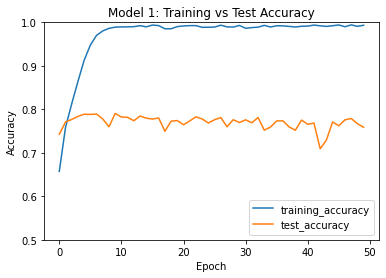

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Test Accuracy")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_1_accuracy_50e")

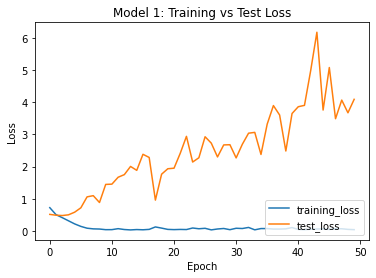

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Test Loss")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_1_loss_50e")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 13s 174ms/step - loss: 4.0984 - accuracy: 0.7587
Test Loss: 4.098391056060791
Test Accuracy: 0.7586501240730286


## Model 2: VGG-3

In [ ]:
# Model 2 specification
def model_2_specification():
    inputs = keras.Input(shape = (180,180,3))
    
    # First block w/ 32 filters
    x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Thir block w/ 128 filters
    x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    
    # Flatten Layers
    x = layers.Flatten()(x)
    
    # Fully Connected Layers
    x = layers.Dense(128, activation = "relu")(x)   
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# Compile
model = model_2_specification()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [ ]:
# Fit, plot and validate the model
step_size_train = train_valid_generator.n//train_valid_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator= train_valid_generator, steps_per_epoch=step_size_train,
                              validation_data=test_generator, validation_steps=step_size_validation,
                              epochs=50,callbacks=[tensorboard]
                              )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
292/292 [==============================] - 83s 283ms/step - loss: 0.6270 - accuracy: 0.6655 - val_loss: 0.5456 - val_accuracy: 0.7239
Epoch 2/50
292/292 [==============================] - 80s 274ms/step - loss: 0.4809 - accuracy: 0.7716 - val_loss: 0.4421 - val_accuracy: 0.7960
Epoch 3/50
292/292 [==============================] - 85s 291ms/step - loss: 0.4047 - accuracy: 0.8148 - val_loss: 0.4250 - val_accuracy: 0.8095
Epoch 4/50
292/292 [==============================] - 86s 294ms/step - loss: 0.3358 - accuracy: 0.8524 - val_loss: 0.4663 - val_accuracy: 0.7947
Epoch 5/50
292/292 [==============================] - 91s 311ms/step - loss: 0.2631 - accuracy: 0.8925 - val_loss: 0.4381 - val_accuracy: 0.8234
Epoch 6/50
292/292 [==============================] - 95s 326ms/step - loss: 0.1815 - accuracy: 0.9301 - val_loss: 0.4664 - val_accuracy: 0.8380
Epoch 7/50
292/292 [==============================] - 84s 287ms/step - loss: 0.1231 - accuracy: 0.9552 - val_loss: 0.4895 - val_ac

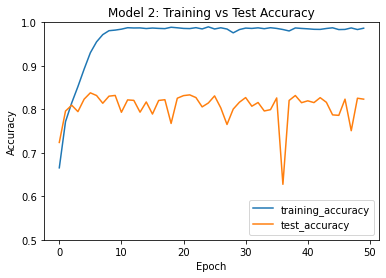

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 2: Training vs Test Accuracy")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_2_accuracy_50epoche_run2")

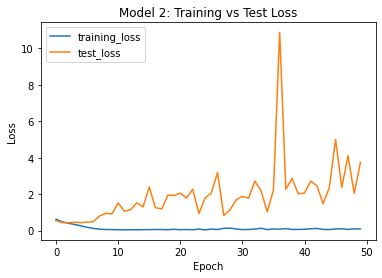

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title("Model 2: Training vs Test Loss")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_2_loss_50epoche_run2")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 15s 199ms/step - loss: 3.7308 - accuracy: 0.8238
Test Loss: 3.7308061122894287
Test Accuracy: 0.8237932324409485


## Model 3: VVG-4

In [ ]:
# Model 3 specification
def model_3_specification():
    inputs = keras.Input(shape = (180,180,3))
    
    # First block w/ 32 filters
    x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Third block w/ 128 filters
    x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    # Fourth block w/ 256 filters
    x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)

    # Fully Connected Layers    
    x = layers.Dense(128, activation = "relu")(x)   
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# Compile
model = model_3_specification()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [ ]:
# Fit, plot and validate the model
step_size_train = train_valid_generator.n//train_valid_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator= train_valid_generator, steps_per_epoch=step_size_train,
                              validation_data=test_generator, validation_steps=step_size_validation,
                              epochs=50,callbacks=[tensorboard]
                              )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
292/292 [==============================] - 78s 265ms/step - loss: 0.6990 - accuracy: 0.5912 - val_loss: 0.5500 - val_accuracy: 0.7254
Epoch 2/50
292/292 [==============================] - 68s 232ms/step - loss: 0.5546 - accuracy: 0.7189 - val_loss: 0.4812 - val_accuracy: 0.7705
Epoch 3/50
292/292 [==============================] - 68s 231ms/step - loss: 0.4550 - accuracy: 0.7885 - val_loss: 0.4327 - val_accuracy: 0.8057
Epoch 4/50
292/292 [==============================] - 69s 236ms/step - loss: 0.3778 - accuracy: 0.8314 - val_loss: 0.3584 - val_accuracy: 0.8354
Epoch 5/50
292/292 [==============================] - 75s 258ms/step - loss: 0.3156 - accuracy: 0.8632 - val_loss: 0.3421 - val_accuracy: 0.8574
Epoch 6/50
292/292 [==============================] - 69s 236ms/step - loss: 0.2561 - accuracy: 0.8921 - val_loss: 0.3457 - val_accuracy: 0.8746
Epoch 7/50
292/292 [==============================] - 68s 232ms/step - loss: 0.2044 - accuracy: 0.9172 - val_loss: 0.3235 - val_ac

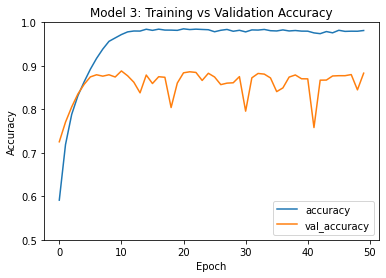

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 3: Training vs Validation Accuracy")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_3_accuracy_50e")

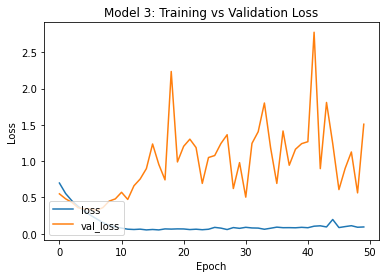

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.title("Model 3: Training vs Validation Loss")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_3_loss_50e")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 13s 175ms/step - loss: 1.5091 - accuracy: 0.8832
Test Loss: 1.509084939956665
Test Accuracy: 0.8831695914268494


## Model 4: VGG-4 w/ Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.01),
        layers.RandomZoom(0.01),
    ]
)

In [ ]:
# Model 4 specification
def model_4_specification():
    inputs = keras.Input(shape = (180,180,3))
    
    x = data_augmentation(inputs)

    # First block w/ 32 filters
    x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.05)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.05)(x)

    # Third block w/ 128 filters
    x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.05)(x)

    # Fourth block w/ 256 filters
    x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.05)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)

    x = layers.Dropout(0.2)(x)

    # Fully Connected Layers    
    x = layers.Dense(128, activation = "relu")(x) 
    x = layers.Dropout(0.2)(x)  
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [ ]:
# Compile
model = model_4_specification()
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [ ]:
# Fit, plot and validate the model
step_size_train = train_valid_generator.n//train_valid_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator = train_valid_generator, steps_per_epoch=step_size_train,
                              validation_data=test_generator, validation_steps=step_size_validation,
                              epochs=50,callbacks=[tensorboard]
                              )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
292/292 [==============================] - 81s 273ms/step - loss: 0.6829 - accuracy: 0.5932 - val_loss: 0.5711 - val_accuracy: 0.7076
Epoch 2/50
292/292 [==============================] - 81s 276ms/step - loss: 0.5655 - accuracy: 0.7123 - val_loss: 0.5273 - val_accuracy: 0.7509
Epoch 3/50
292/292 [==============================] - 83s 286ms/step - loss: 0.4954 - accuracy: 0.7595 - val_loss: 0.4540 - val_accuracy: 0.7967
Epoch 4/50
292/292 [==============================] - 85s 293ms/step - loss: 0.4384 - accuracy: 0.7974 - val_loss: 0.5087 - val_accuracy: 0.7716
Epoch 5/50
292/292 [==============================] - 79s 271ms/step - loss: 0.3929 - accuracy: 0.8242 - val_loss: 0.3711 - val_accuracy: 0.8405
Epoch 6/50
292/292 [==============================] - 83s 286ms/step - loss: 0.3621 - accuracy: 0.8434 - val_loss: 0.3301 - val_accuracy: 0.8568
Epoch 7/50
292/292 [==============================] - 78s 267ms/step - loss: 0.3314 - accuracy: 0.8579 - val_loss: 0.3335 - val_ac

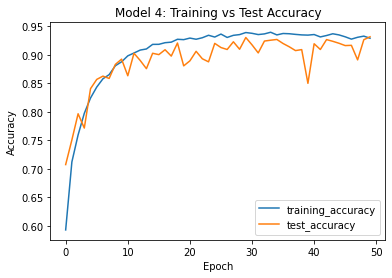

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 4: Training vs Test Accuracy")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_4_accuracy")

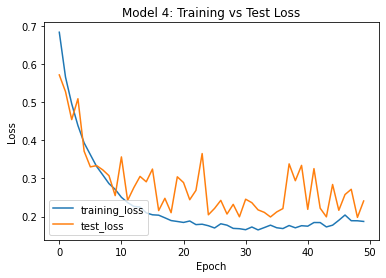

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.title("Model 4: Training vs Test Loss")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_4_loss")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 14s 187ms/step - loss: 0.2409 - accuracy: 0.9312
Test Loss: 0.2408558875322342
Test Accuracy: 0.9312259554862976


## Model 5: Hyperparameter tuning

In [ ]:
# Define a HyperModel class
def build_hypermodel(hp):
    inputs = keras.Input(shape = (180,180,3))
    
    data_augmentation = hp.Float("data_augmentation", min_value = 0.01, max_value = 0.1, step = 0.01)
    dropout_hidden_layer = hp.Float("dropout_hidden_layer", min_value = 0.05, max_value = 0.1, step = 0.01)
    dropout_flatten_layer = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)


    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(data_augmentation)(x)
    x = layers.RandomZoom(data_augmentation)(x)

    # First block w/ 32 filters
    x = layers.Conv2D(filters = hp.Int("convolution_1_filters", min_value = 16, max_value = 64, step = 16), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Second block w/ 64 filters
    x = layers.Conv2D(filters = hp.Int("convolution_2_filters", min_value = 64, max_value = 128, step = 32), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Third block w/ 128 filters
    x = layers.Conv2D(filters = hp.Int("convolution_3_filters", min_value = 128, max_value = 256, step = 64), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)

    # Fourth block w/ 256 filters
    x = layers.Conv2D(filters = hp.Int("convolution_4_filters", min_value = 256, max_value = 512, step=128), kernel_size = 3, activation = "relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(dropout_hidden_layer)(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)

    x = layers.Dropout(dropout_flatten_layer)(x)

    # First Fully Connected Layers    
    x = layers.Dense(hp.Int("num_units", min_value = 64, max_value = 256, step = 64), activation = "relu")(x) 

    # Second Fully Connected Layers    
    x = layers.Dropout(dropout_flatten_layer)(x)
    x = layers.Dense(hp.Int("num_units_second_layer", min_value = 64, max_value = 256, step=64), activation="relu")(x)

    # Last Fully Connected Layer
    x = layers.Dropout(dropout_flatten_layer)(x)  
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# Tuner
tuner = kt.BayesianOptimization(build_hypermodel, objective="val_accuracy", max_trials=17, 
                                directory="./drive/MyDrive/cats_dogs_logs_run2",
                                project_name="cats_dogs_classification",
                                overwrite=False)

In [ ]:
# Summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
data_augmentation (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': 0.01, 'sampling': None}
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.1, 'step': 0.01, 'sampling': None}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
convolution_4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': None}
num_units (Int)
{'default': None, '

In [ ]:
# Stop the training when you start overfitting
stop_early = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]

In [ ]:
# Start the search! 
tuner.search(train_generator, batch_size=64, epochs=100, validation_data=valid_generator,
             callbacks=stop_early)

Trial 17 Complete [00h 21m 00s]
val_accuracy: 0.9014949202537537

Best val_accuracy So Far: 0.9239188432693481
Total elapsed time: 02h 11m 57s


In [ ]:
# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hyperparameters.values

{'data_augmentation': 0.01,
 'dropout_hidden_layer': 0.1,
 'dropout_flatten_layer': 0.5000000000000001,
 'convolution_1_filters': 64,
 'convolution_2_filters': 128,
 'convolution_3_filters': 128,
 'convolution_4_filters': 512,
 'num_units': 256,
 'num_units_second_layer': 256}

In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Train the model on the training set for 50 epochs
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
history = hypermodel.fit(train_generator, epochs=50, validation_data = valid_generator, callbacks = stop_early)

# Get the best hepoch, i.e. the epoch with highest validation accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
235/235 [==============================] - 68s 281ms/step - loss: 0.7462 - accuracy: 0.5326 - val_loss: 0.6710 - val_accuracy: 0.6086
Epoch 2/50
235/235 [==============================] - 67s 283ms/step - loss: 0.6492 - accuracy: 0.6410 - val_loss: 0.5788 - val_accuracy: 0.7088
Epoch 3/50
235/235 [==============================] - 66s 281ms/step - loss: 0.5879 - accuracy: 0.6986 - val_loss: 0.5454 - val_accuracy: 0.7282
Epoch 4/50
235/235 [==============================] - 65s 278ms/step - loss: 0.5306 - accuracy: 0.7382 - val_loss: 0.4531 - val_accuracy: 0.8019
Epoch 5/50
235/235 [==============================] - 67s 284ms/step - loss: 0.4855 - accuracy: 0.7771 - val_loss: 0.4957 - val_accuracy: 0.7867
Epoch 6/50
235/235 [==============================] - 66s 279ms/step - loss: 0.4546 - accuracy: 0.7938 - val_loss: 0.4098 - val_accuracy: 0.8147
Epoch 7/50
235/235 [==============================] - 66s 280ms/step - loss: 0.4227 - accuracy: 0.8120 - val_loss: 0.3779 - val_ac

In [ ]:
# Re-instantiate the model w/ optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Retrain the model on the optimal number of epochs
history = hypermodel.fit(train_valid_generator, epochs = int(best_epoch*1.2), validation_data = test_generator)


Epoch 1/25
293/293 [==============================] - 86s 286ms/step - loss: 0.7448 - accuracy: 0.5445 - val_loss: 0.6572 - val_accuracy: 0.6519
Epoch 2/25
293/293 [==============================] - 84s 287ms/step - loss: 0.6112 - accuracy: 0.6735 - val_loss: 0.5845 - val_accuracy: 0.6952
Epoch 3/25
293/293 [==============================] - 83s 283ms/step - loss: 0.5329 - accuracy: 0.7395 - val_loss: 0.4771 - val_accuracy: 0.7843
Epoch 4/25
293/293 [==============================] - 83s 283ms/step - loss: 0.4977 - accuracy: 0.7689 - val_loss: 0.4608 - val_accuracy: 0.7858
Epoch 5/25
293/293 [==============================] - 81s 277ms/step - loss: 0.4514 - accuracy: 0.7991 - val_loss: 0.4253 - val_accuracy: 0.8167
Epoch 6/25
293/293 [==============================] - 82s 281ms/step - loss: 0.4229 - accuracy: 0.8095 - val_loss: 0.5946 - val_accuracy: 0.7157
Epoch 7/25
293/293 [==============================] - 81s 275ms/step - loss: 0.3949 - accuracy: 0.8282 - val_loss: 0.3659 - val_ac

In [ ]:
hypermodel.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                      

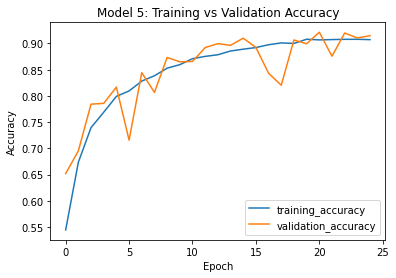

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Model 5: Training vs Validation Accuracy")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_5_accuracy")

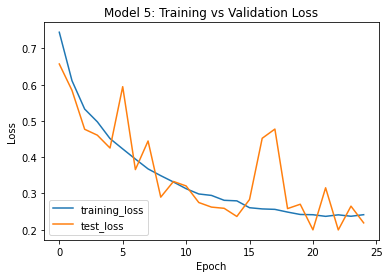

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.title("Model 5: Training vs Validation Loss")
plt.savefig("./drive/MyDrive/cats_dogs_results/model_5_loss")

In [ ]:
test_loss, test_acc = hypermodel.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

74/74 [==============================] - 15s 195ms/step - loss: 0.2189 - accuracy: 0.9148
Test Loss: 0.21886062622070312
Test Accuracy: 0.9147800207138062


## Cross-Validation

In [ ]:
TEST_ACCURACY = []
TEST_LOSS = []

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
kf2 = KFold(n_splits = 5, shuffle = True, random_state = 123)
count = 1

for val_train_index, test_index in kf.split(ash_df):
    # FIRST SPLIT: train+validation set and test set
    val_train, df_test = ash_df.iloc[val_train_index], ash_df.iloc[test_index]
    print("\n")
    print("======================================================================")
    print("Cross validation split n. --> "+ str(count))
    
    train, validation = next(kf2.split(val_train))
    
    # SECOND SPLIT: train set and validation set
    df_train, df_validation = val_train.iloc[train], val_train.iloc[validation]
    print("training set has length " + str(len(train)))
    print("validation set has length " + str(len(validation)))
    print("test set has length " + str(len(test_index)))
    print("---------------------------------------------------------------------")

    # GENERATORS
    train_data_generator = image_data_generator.flow_from_dataframe(df_train, 
                                                   directory = None,
                                                   x_col = "file_name", 
                                                   y_col = "label",
                                                   class_mode = "binary", 
                                                   shuffle = True,
                                                   seed = 666,
                                                   target_size=(180,180), 
                                                  batch_size = 64)
    
    valid_data_generator  = image_data_generator.flow_from_dataframe(df_validation, 
                                                    directory = None, 
                                                    x_col = "file_name",
                                                    y_col = "label",
                                                    class_mode = "binary", 
                                                    shuffle = True,
                                                    seed = 666,
                                                    target_size=(180,180),
                                                   batch_size = 64)
    
    test_data_generator = image_data_generator.flow_from_dataframe(df_test, 
                                                  directory = None, 
                                                  seed = 666,
                                                  x_col = "file_name",
                                                  y_col = "label",
                                                  class_mode = "binary", 
                                                  shuffle = True, 
                                                  target_size=(180,180),
                                                  batch_size = 64)
    
    # CREATE NEW MODEL
    model = model_4_specification()

    # COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy',optimizer="rmsprop", metrics=['accuracy'])
    
    # TENSORBOARD
    tensorboard = keras.callbacks.TensorBoard(log_dir = "./results")
    
    
    # FIT
    history = model.fit(train_data_generator,
                    validation_data = valid_data_generator,
                    steps_per_epoch = train_data_generator.n//train_data_generator.batch_size,
                    validation_steps = valid_data_generator.n//valid_data_generator.batch_size,
                    epochs = 50,
                    callbacks = [tensorboard])

    with open(f'./drive/MyDrive/cats_dogs_history/trainHistoryDict_split{count}', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # EVALUATE RESULTS
    print("---------------------------------------------------------------------")
    print("Evaluating the results....")
    results = model.evaluate(test_data_generator)
    results = dict(zip(model.metrics_names,results))
    
    TEST_ACCURACY.append(results['accuracy'])
    TEST_LOSS.append(results['loss'])
    
    
    tf.keras.backend.clear_session()



Cross validation split n. --> 1
training set has length 14982
validation set has length 3746
test set has length 4682
---------------------------------------------------------------------
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/50
234/234 [==============================] - 72s 300ms/step - loss: 0.7493 - accuracy: 0.5628 - val_loss: 0.6473 - val_accuracy: 0.6471
Epoch 2/50
234/234 [==============================] - 62s 263ms/step - loss: 0.6108 - accuracy: 0.6717 - val_loss: 0.5405 - val_accuracy: 0.7320
Epoch 3/50
234/234 [==============================] - 70s 298ms/step - loss: 0.5446 - accuracy: 0.7323 - val_loss: 0.4942 - val_accuracy: 0.7659
Epoch 4/50
234/234 [==============================] - 69s 294ms/step - loss: 0.4939 - accuracy: 0.7644 - val_loss: 0.4307 - val_accuracy: 0.8063
Epoch 5/50
234/234 [==========================

In [ ]:
print("Test Accuracy_- CV Estimate: " + str(st.mean(TEST_ACCURACY)))
print("Test Loss - CV Estimate: " + str(st.mean(TEST_LOSS)))

Test Accuracy_- CV Estimate: 0.917214858531952
Test Loss - CV Estimate: 0.22890323400497437


In [ ]:
loss_list = []
accuracy_list = []
val_loss_list = []
val_accuracy_list = []
for i in range(1,6):
  with open(f"./drive/MyDrive/cats_dogs_history/trainHistoryDict_split{i}", "rb") as input_file:
    e = pickle.load(input_file)
    loss_list.append(e["loss"])
    accuracy_list.append((e["accuracy"]))
    val_loss_list.append((e["val_loss"]))
    val_accuracy_list.append((e["val_accuracy"]))

In [ ]:
color_dict = {1:"deepskyblue", 2: "steelblue", 3:"dodgerblue", 4: "blue", 5: "royalblue"}

In [ ]:
color_dict_2 = {1:"orange", 2: "darkorange", 3:"darkgoldenrod", 4: "gold", 5: "moccasin"}

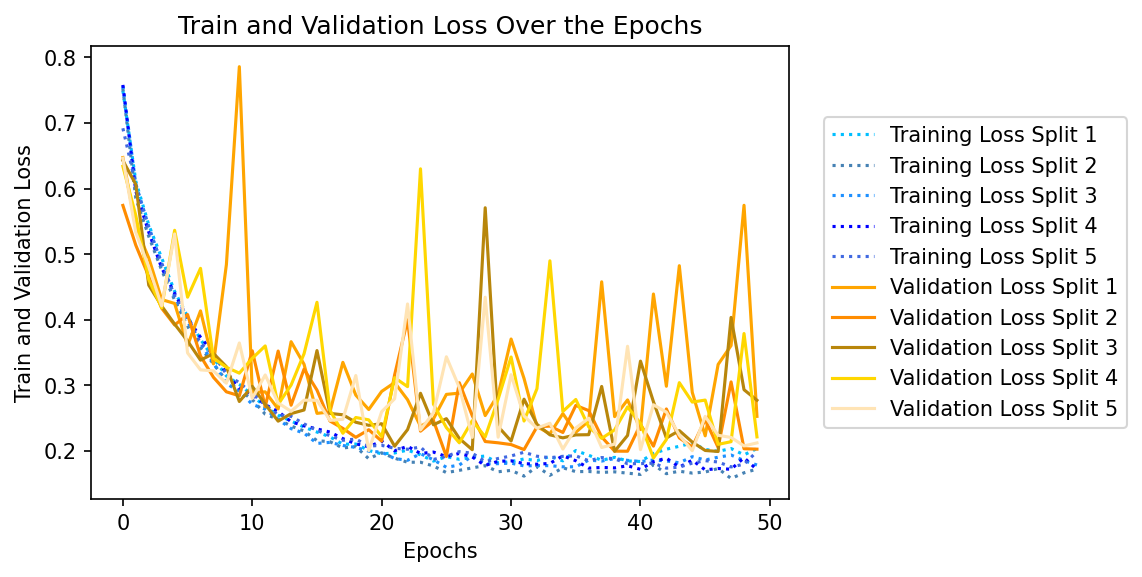

In [ ]:
fig = plt.figure(dpi=150)
plt.xlabel("Epochs")
plt.ylabel("Train and Validation Loss")
plt.title("Train and Validation Loss Over the Epochs")
count=1
for i in loss_list:
  plt.plot(i, label = f"Training Loss Split {count}", linestyle='dotted', color = color_dict[count])
  count+=1
count=1
for i in val_loss_list:
  plt.plot(i, label = f"Validation Loss Split {count}", linestyle='solid', color = color_dict_2[count])
  count+=1

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fancybox=True)
plt.savefig("./drive/MyDrive/cats_dogs_results/cross_validation_loss_run2")

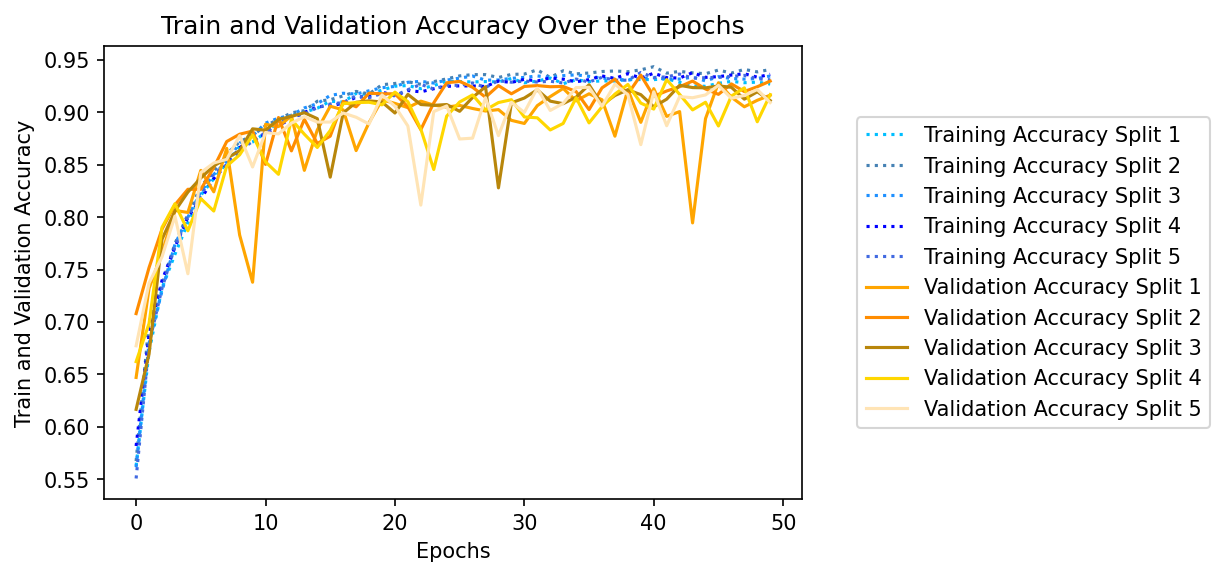

In [ ]:
fig = plt.figure(dpi=150)
plt.xlabel("Epochs")
plt.ylabel("Train and Validation Accuracy")
plt.title("Train and Validation Accuracy Over the Epochs")
count=1
for i in accuracy_list:
  plt.plot(i, label = f"Training Accuracy Split {count}", linestyle='dotted', color = color_dict[count])
  count+=1
count=1
for i in val_accuracy_list:
  plt.plot(i, label = f"Validation Accuracy Split {count}", linestyle='solid', color = color_dict_2[count])
  count+=1

plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), fancybox=True)
plt.savefig("./drive/MyDrive/cats_dogs_results/cross_validation_accuracy_run2")